# The HD Code - DELFT

The Set of Codes to run Ocean Parcels to use text files as starting locations and starting times

Import the appropriate modules that are used in the code.

In [27]:
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, ErrorCode, plotTrajectoriesFile
import numpy as np
import math
from datetime import timedelta
from operator import attrgetter
from netCDF4 import Dataset
import netCDF4
import pandas
from datetime import timedelta
from datetime import datetime

This is the input of the raw drifter starting locations. This file contains drifter IDs, date (starting), days_travelled, starting lon and latitudes. Note this is written for a text file and will need to be adjusted for a different file type.

In [ ]:
drifters = pandas.read_csv("/Users/hart-davis/Desktop/Scripts/Drifter_Starting_Locations2.txt", sep="\t")

Start of the loop that is used. This is designed to account for a large amount of drifters.
Start = The Starting Date to run the synthetic particle tracker.
Date = Is the starting date in the appropriate format.
Travel = The amount of days to run the synthetic particle tracker for. 
ID = The ID of the drifter that is being used in this iteration.
Dates = The dates for which to run the particle tracker. From start to finish.

Globfiles = This is the exact files that the synthetic particle tracker will use from GlobCurrent. It then uses files from 20000101 to 20000110 for example to run the synthetic particle tracker. This allows for the correct time period to be used during comparisons.

Plots the results of the simulation above. Make sure to adjust the file name to where you have saved the output. Tracerfile is the background of the image you want to illustrate, the GlobCurrent velocity field.

The filenames are the files that the synthetic particle tracker uses to run the simulations. It uses globfiles which tells it exactly which files to use. This is computationally efficient and increases accuracy. U - x velocity component, V - y velocity component. Variables extract the velocity data that will be used to force the synthetic particle tracker and the dimensions are the global reference point and the time.

In this step, I have set up the code to make it easier for users to use the code. lonD is the furthest eastward longitudinal point, lonD1 is the furthest westward longitudinal point, latD is the furthest northward latitudinal point and latD1 is the furthest southward latitudinal point.

sim_days is the number of days the particle tracker will be run for. part is the number of particle you want to deploy in the particle tracker. In this case, the drifter.lon[x] calls the starting longitudinal point of the observed drifter that is being used in this iteration. 

This next step calls the variables that we have defined in the previous step.

The hours is the hourly output that you want to get from the synthetic particle tracker. 6-Hourly is used in this case so that it can be compared to the drifter trajectories. This number can be hourly, daily (24) etc. name is the name you want to name the file, while str(ID) gives the PARCEL the same name as the drifter that it is being compared to. 

In [66]:

globfiles = ["/Users/hart-davis/Desktop/Test_output/state_Test_2015-01-02_00-00-00/Test_20150102_000000_rst.nc"]

globe = ["/Users/hart-davis/Desktop/Test_output/DFM_OUTPUT_Test/Test_map.nc"]

lon2 = nc.variables["NetNode_x"][:]
lat2 = nc.variables["NetNode_y"][:]
u = nc.variables["ucx"][:]
v = nc.variables["ucy"][:]
w = nc.variables["ucz"][:]

lon1 = lon2[:len(u)]

lat1 = lat2[:len(v)]

filenames = {'U': globe,
             'V': globe}

variables = {'U': "NetNode_x",
             'V': "NetNode_y"}

dimensions = {'lat': "NetNode_y",
              'lon': "NetNode_x",
              'time': 'time'}

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, allow_time_extrapolation=True)

pset = ParticleSet.from_line(fieldset=fieldset, size=5, pclass=JITParticle, 
                             start=(14.8504999999999999, -32.9804000000000002), finish=(14.8504999999999999, -32.9804000000000002))

output_file = pset.ParticleFile(name="testing3")
pset.execute(AdvectionRK4, starttime=datetime(2008, 1,1), runtime=timedelta(days=70),
             dt=timedelta(minutes=5), interval=timedelta(hours=6),output_file=output_file)

plotTrajectoriesFile('testing3.nc')



IndexError: tuple index out of range

()

In [ ]:


nc = netCDF4.Dataset("/Users/hart-davis/Desktop/Test_output/state_Test_2015-01-02_00-00-00/Test_20150102_000000_rst.nc")

nc.variables["ucx"]

lon = nc.variables["ucx"][0,:,0]
lon.shape

lat = nc.variables["ucy"][0,0,:]
lat.shape

In [ ]:
from netCDF4 import date2index
import netCDF4
import numpy as np
import xarray as xr, xray
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from datetime import datetime
from matplotlib.pyplot import hold, figure, pcolor, colorbar, xlabel, ylabel, title, draw, quiver, show, savefig
import cmocean as cm
import matplotlib.patches as mpatches
import pandas
import matplotlib as mpl

cmap = cm.cm.balance

tset = "/Users/hart-davis/Desktop/Scripts/testing2.nc"
ts = netCDF4.Dataset(tset)

#hycom

loni = ts.variables["lon"][:]
lati = ts.variables["lat"][:]

nset = "/Users/hart-davis/Desktop/Scripts/testing3.nc"
nc = netCDF4.Dataset(nset)

#globcurrent

llon = nc.variables["lon"][:]
llat = nc.variables["lat"][:]

date = ts.variables["time"][0]
d = date - 630720000
a = (d.data-d.data[0])/3600/24
a = np.array(a)

m = Basemap(projection = "merc", resolution="i",llcrnrlon = 0, 
            llcrnrlat = -43, urcrnrlon = 40, urcrnrlat = -20,lat_0= -20,lon_0 = 0)

globfiles = "/Users/hart-davis/Desktop/Scripts/GEBCO_2014_6x6min_Global.nc"

nc = netCDF4.Dataset(globfiles)

ssh = nc.variables["Height"][:]
lon = nc.variables["lon"][:]
lat = nc.variables["lat"][:]
figure1 = figure(figsize=(13, 10), dpi=160, facecolor='w', edgecolor='k')
xx, yy = m(*np.meshgrid(lon,lat))
f1,f2 = m(loni,lati)
s1,s2 = m(llon,llat)

cntour = m.contourf(xx,yy,ssh,cmap=cm.cm.gray_r,levels=np.linspace(-6000,1,100),alpha=0.1,zorder=1)

ax = m.scatter(s1[:len(loni[0])],s2[:len(lati[0])],20,color="deepskyblue", marker = "o", alpha = 1,zorder=3)
m.scatter(f1,f2,10,color="red", marker = "o", alpha = 1, zorder=3)

#Blue=GC
#Red = Hycom

m.drawcoastlines()
m.fillcontinents()
m.drawmapboundary()
#m.bluemarble()
m.drawparallels(np.arange(-90.,99.,10), color="k",labels=[1,0,0,0],fontsize=15)
m.drawmeridians(np.arange(-180.,180.,10), color="k",labels=[0,0,0,1],fontsize=15)

plt.show()

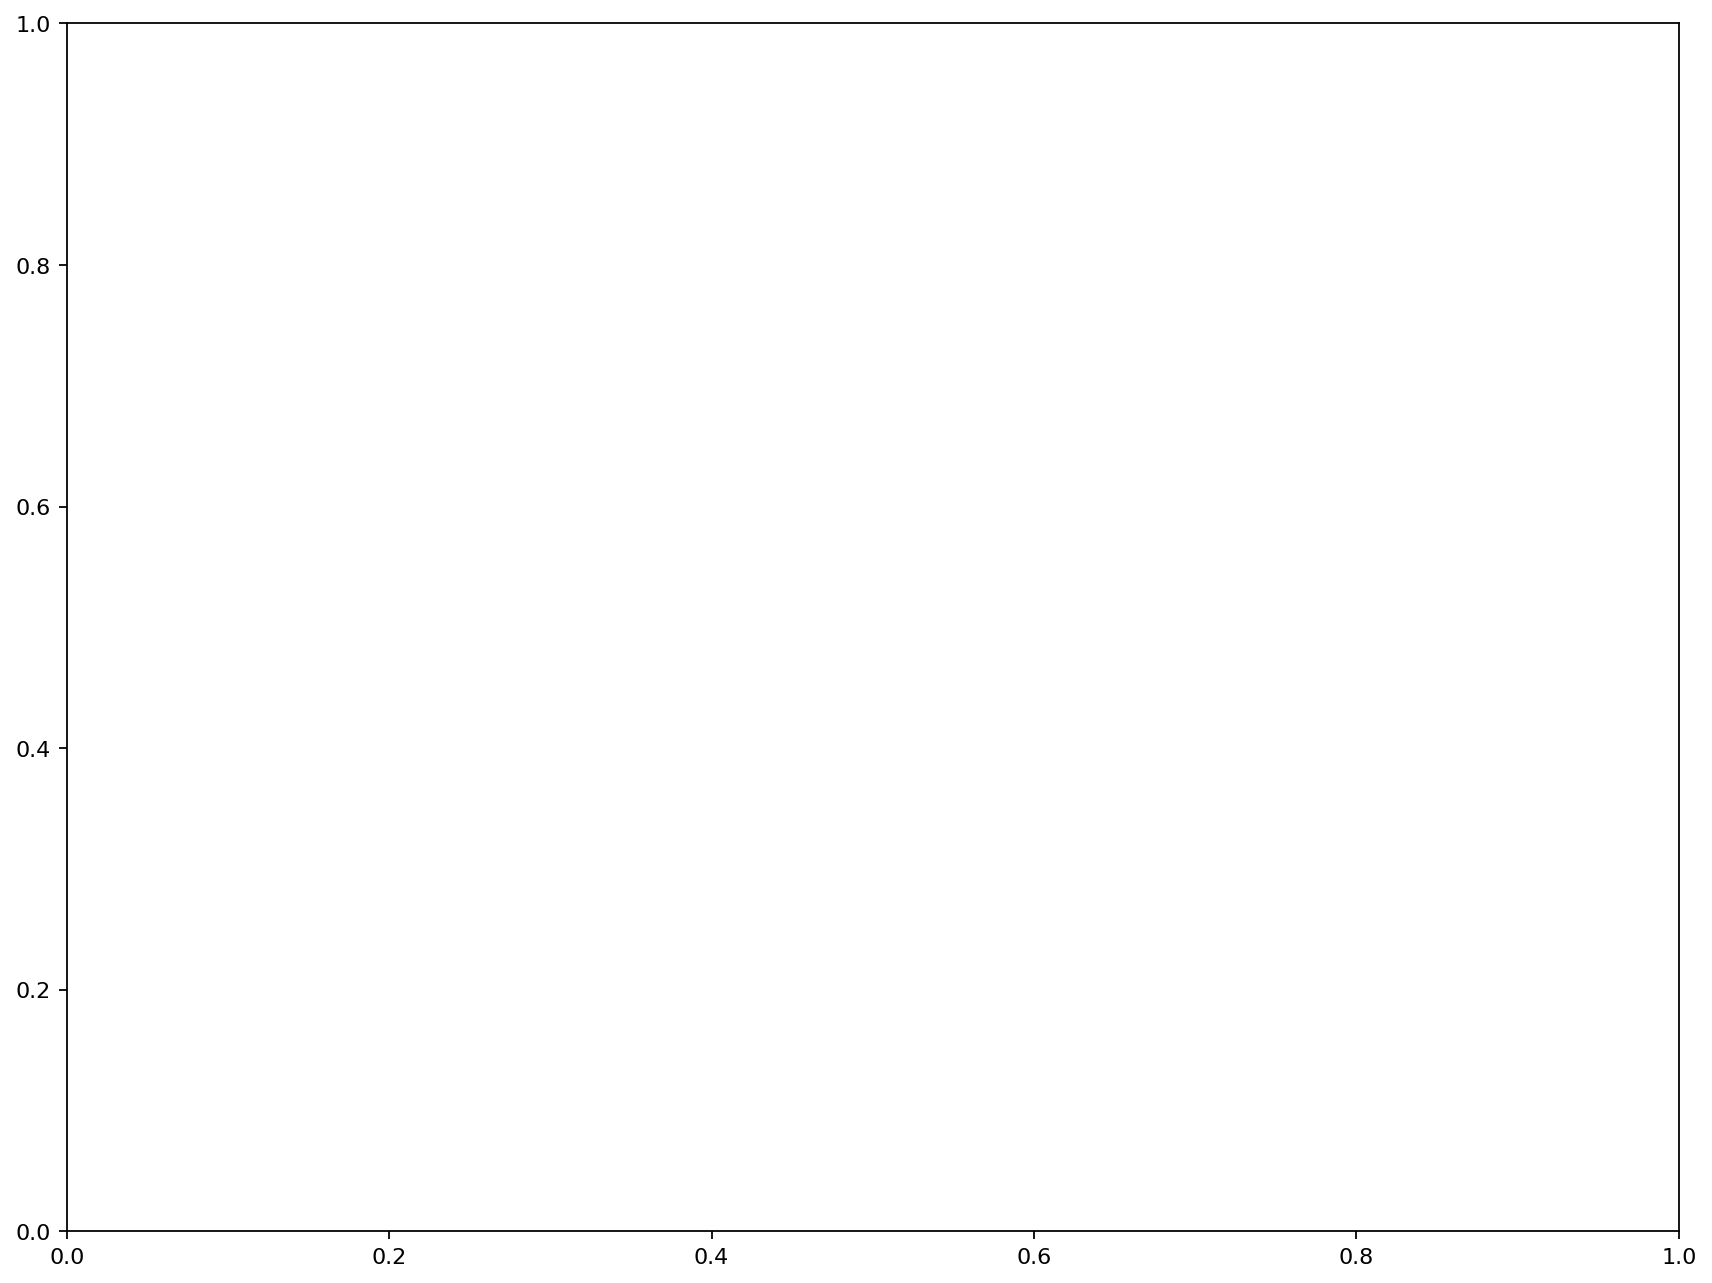

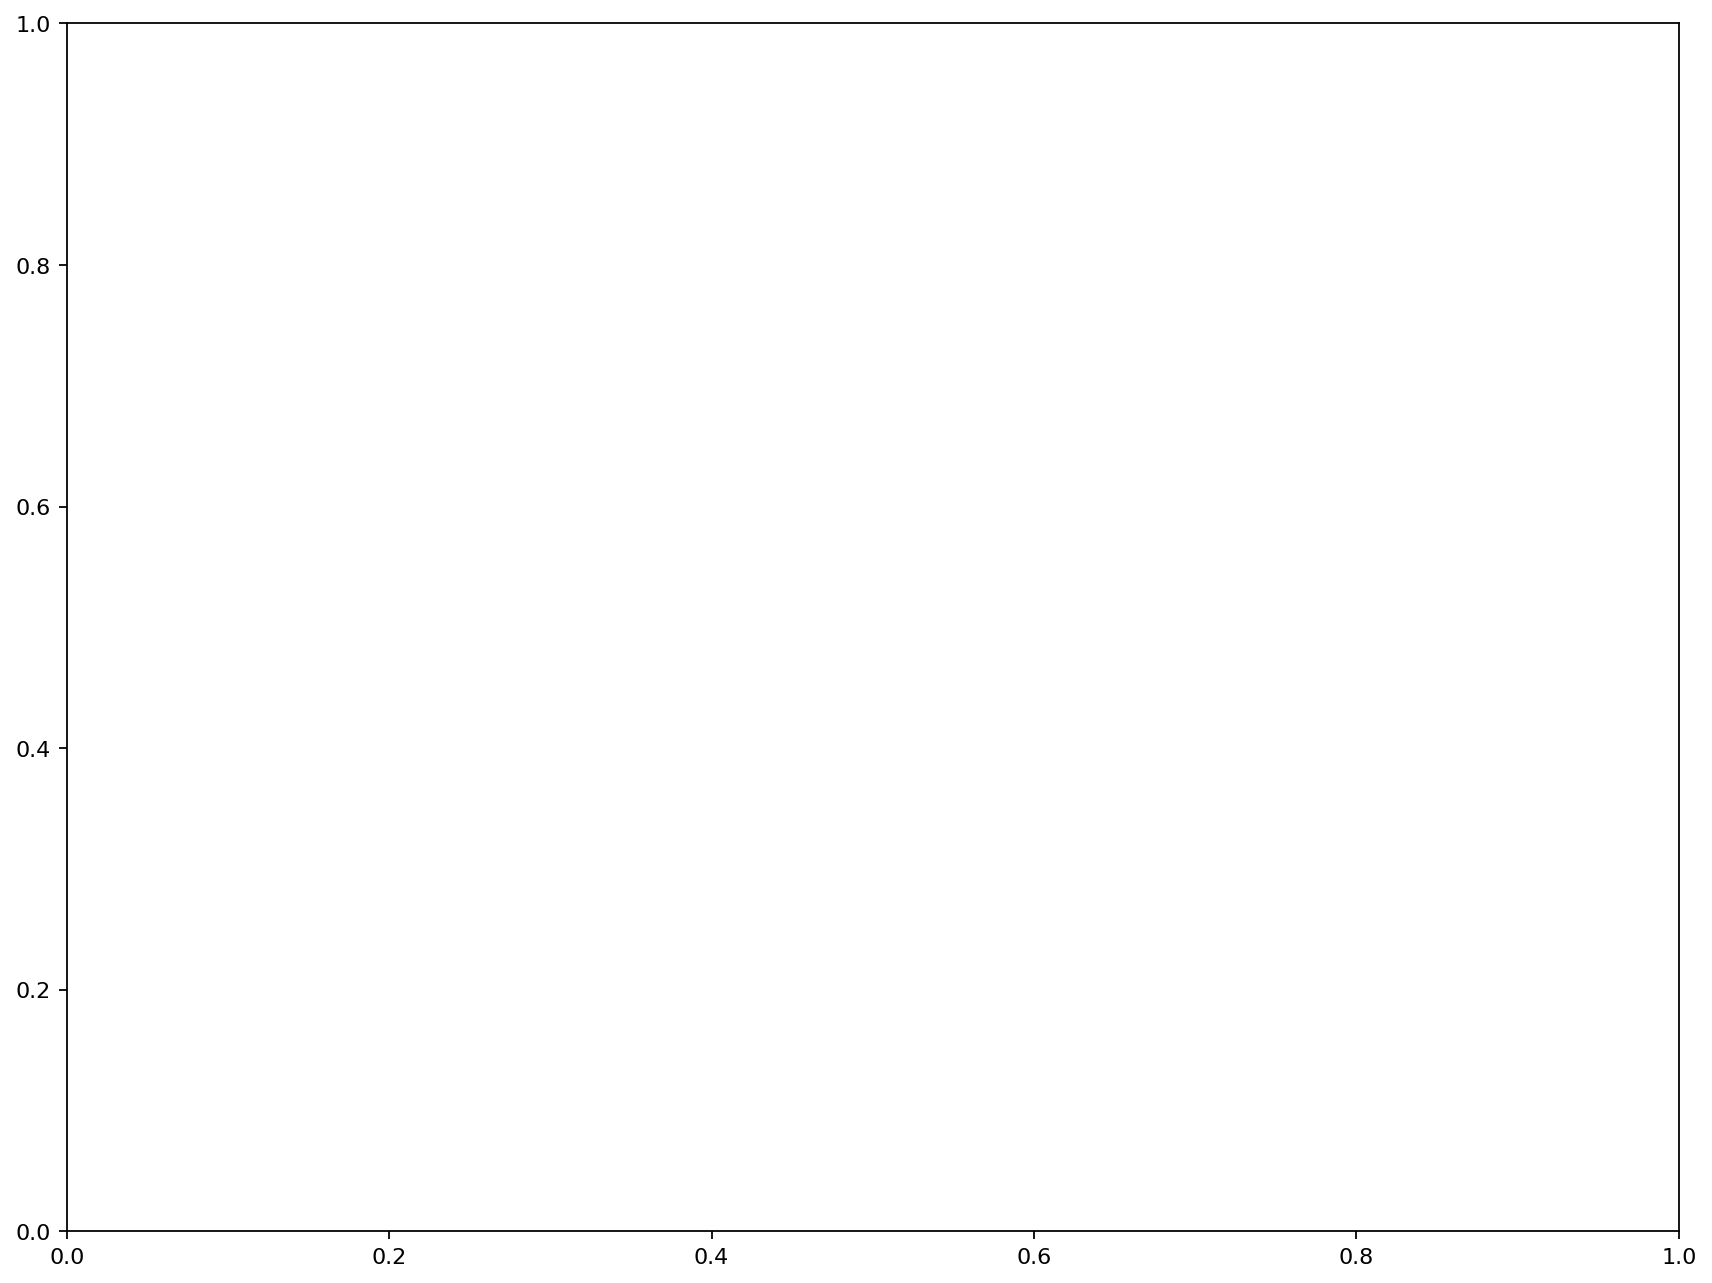

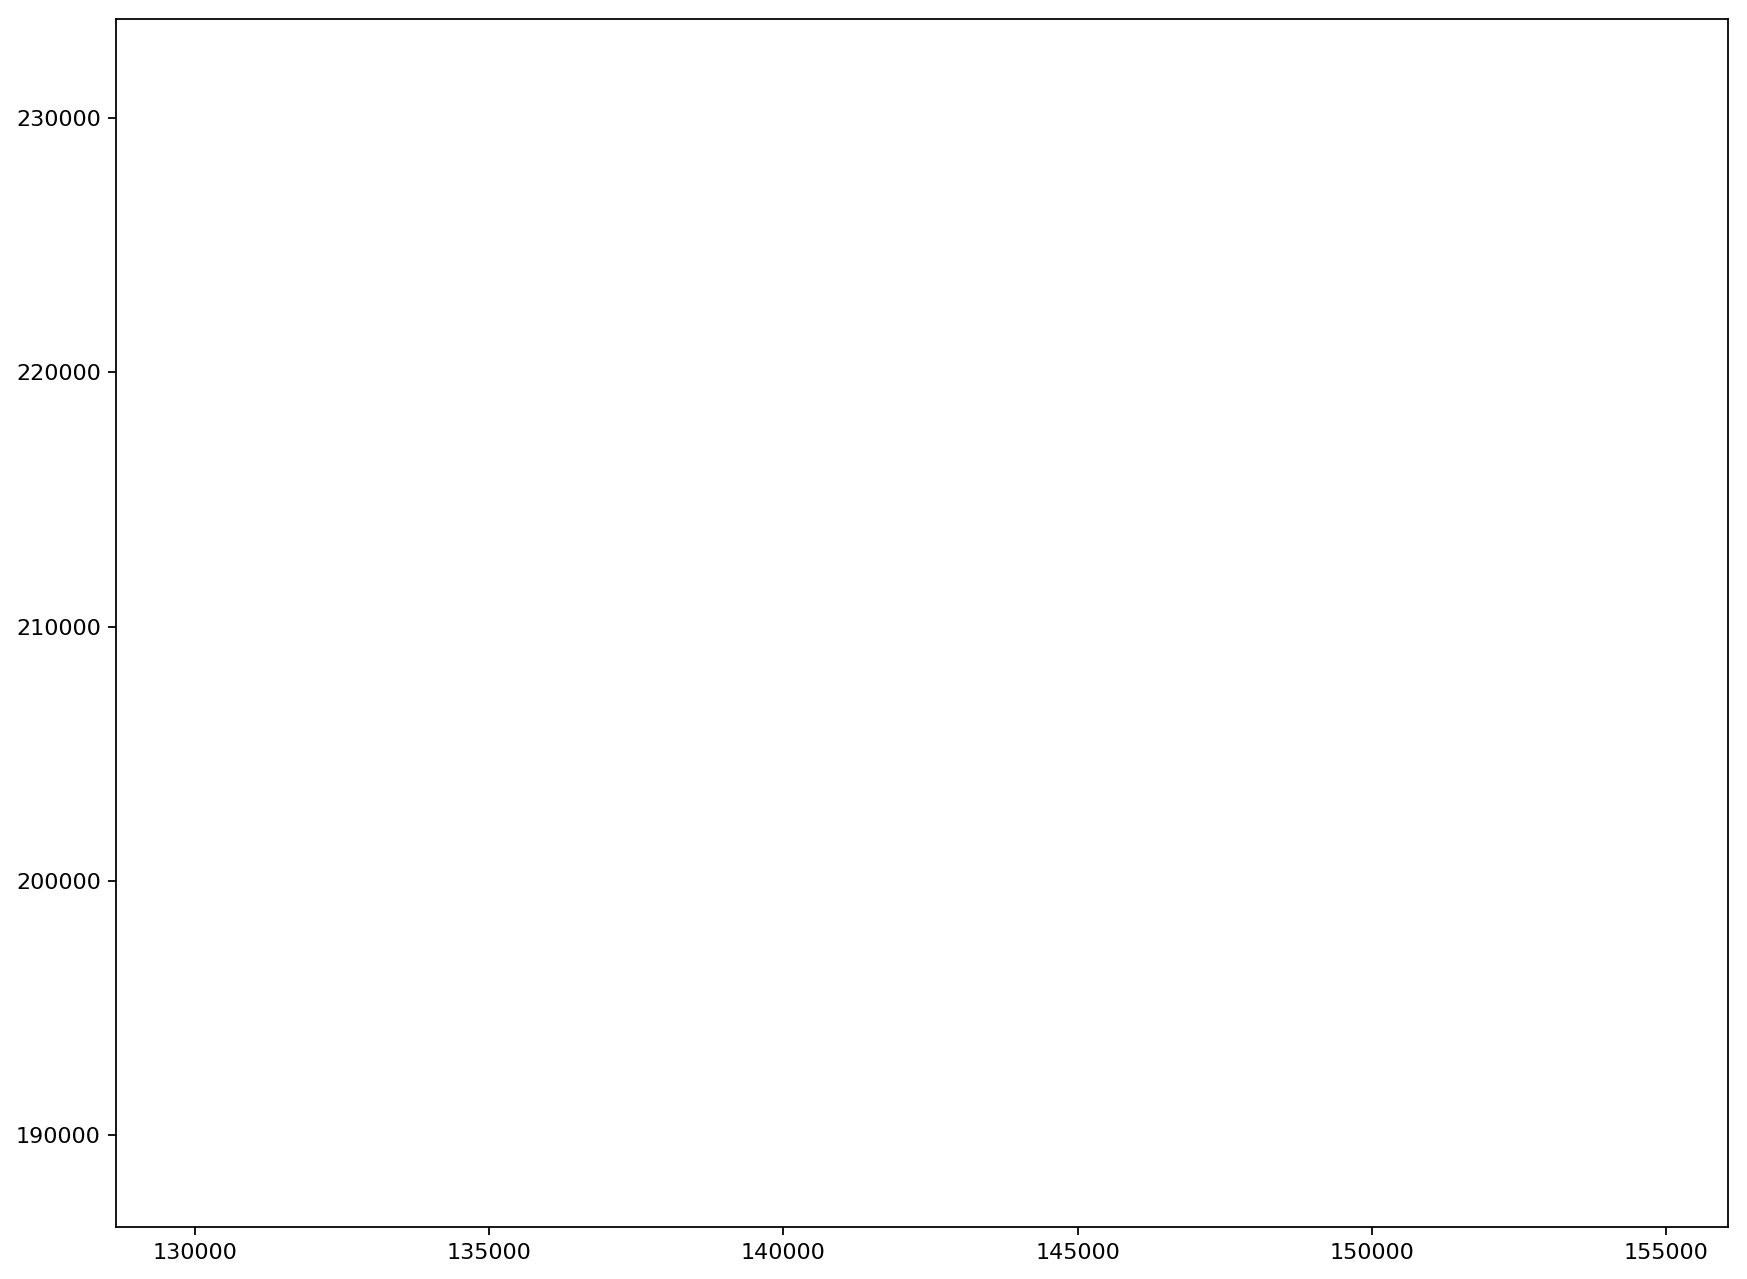

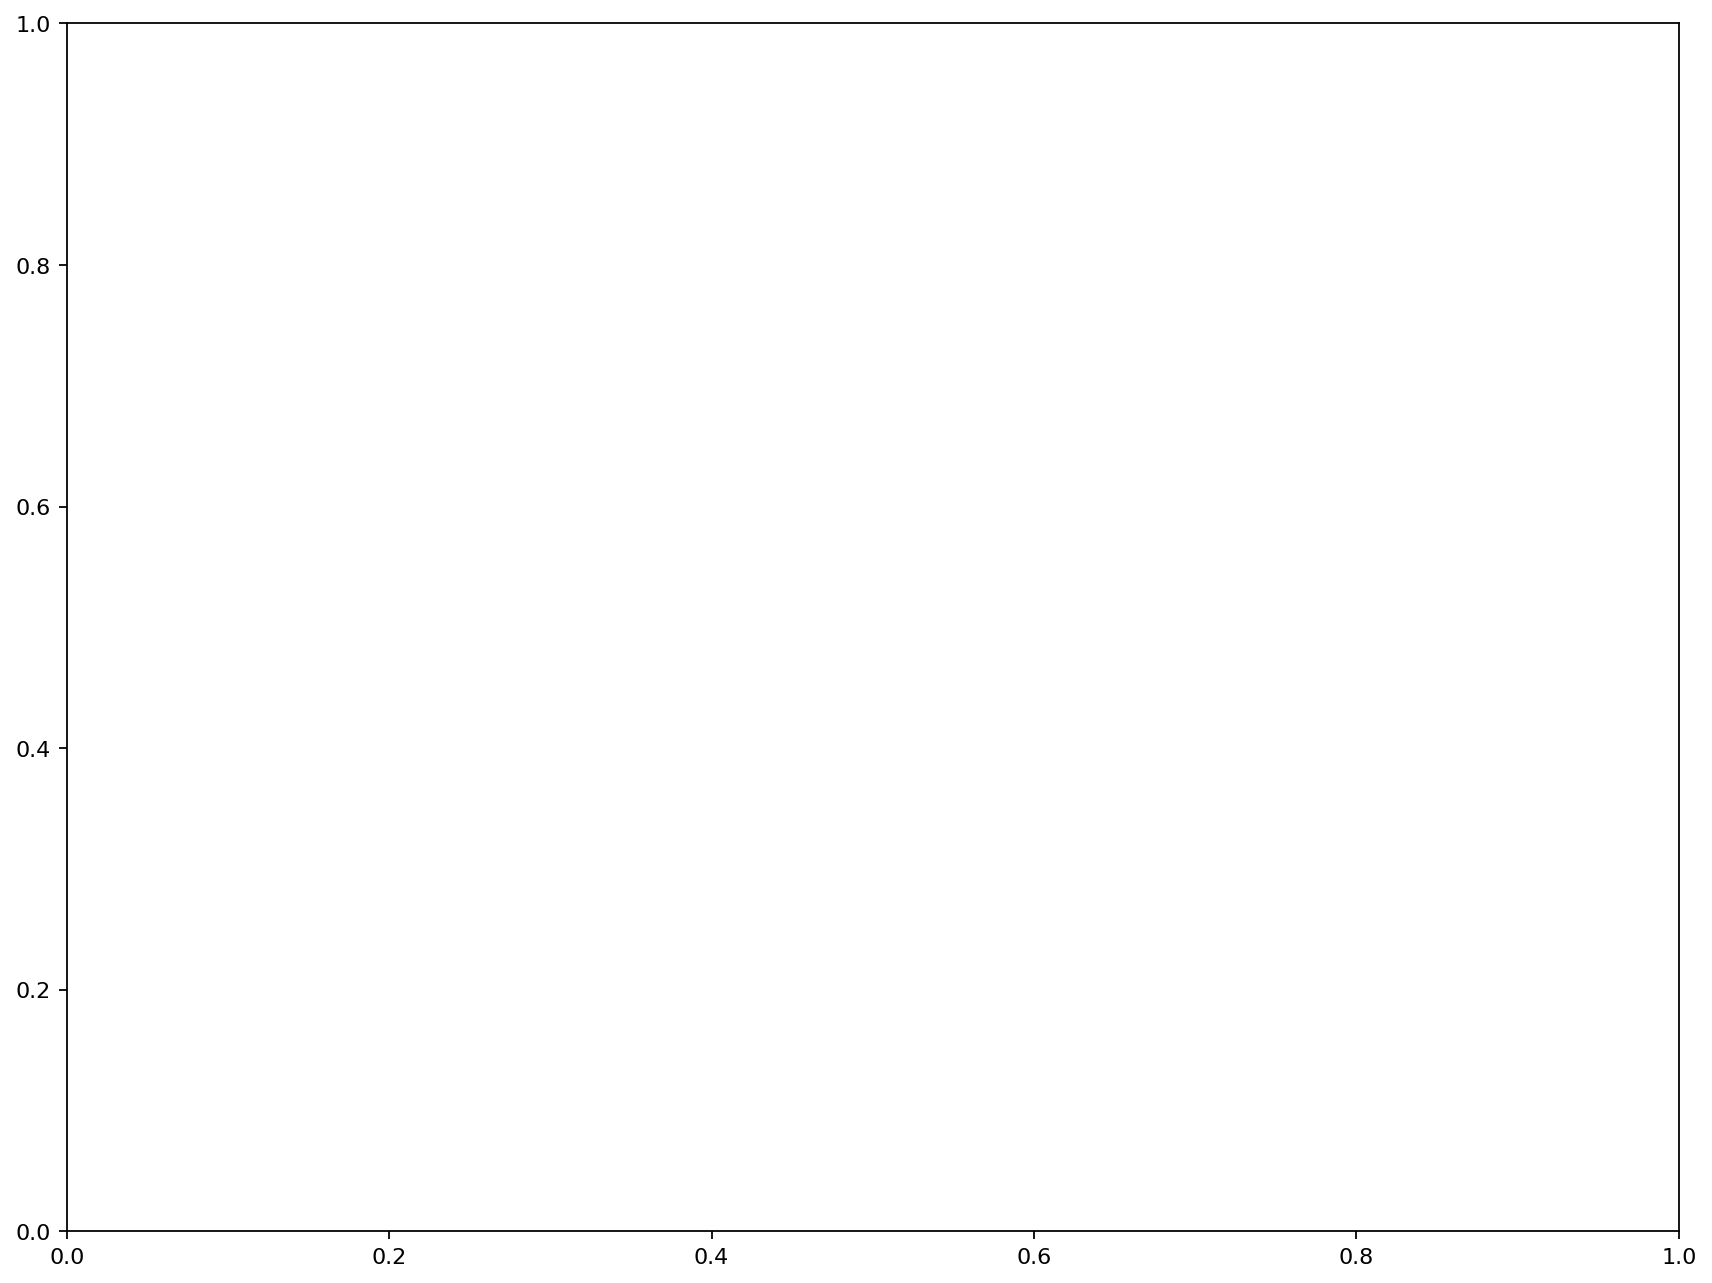

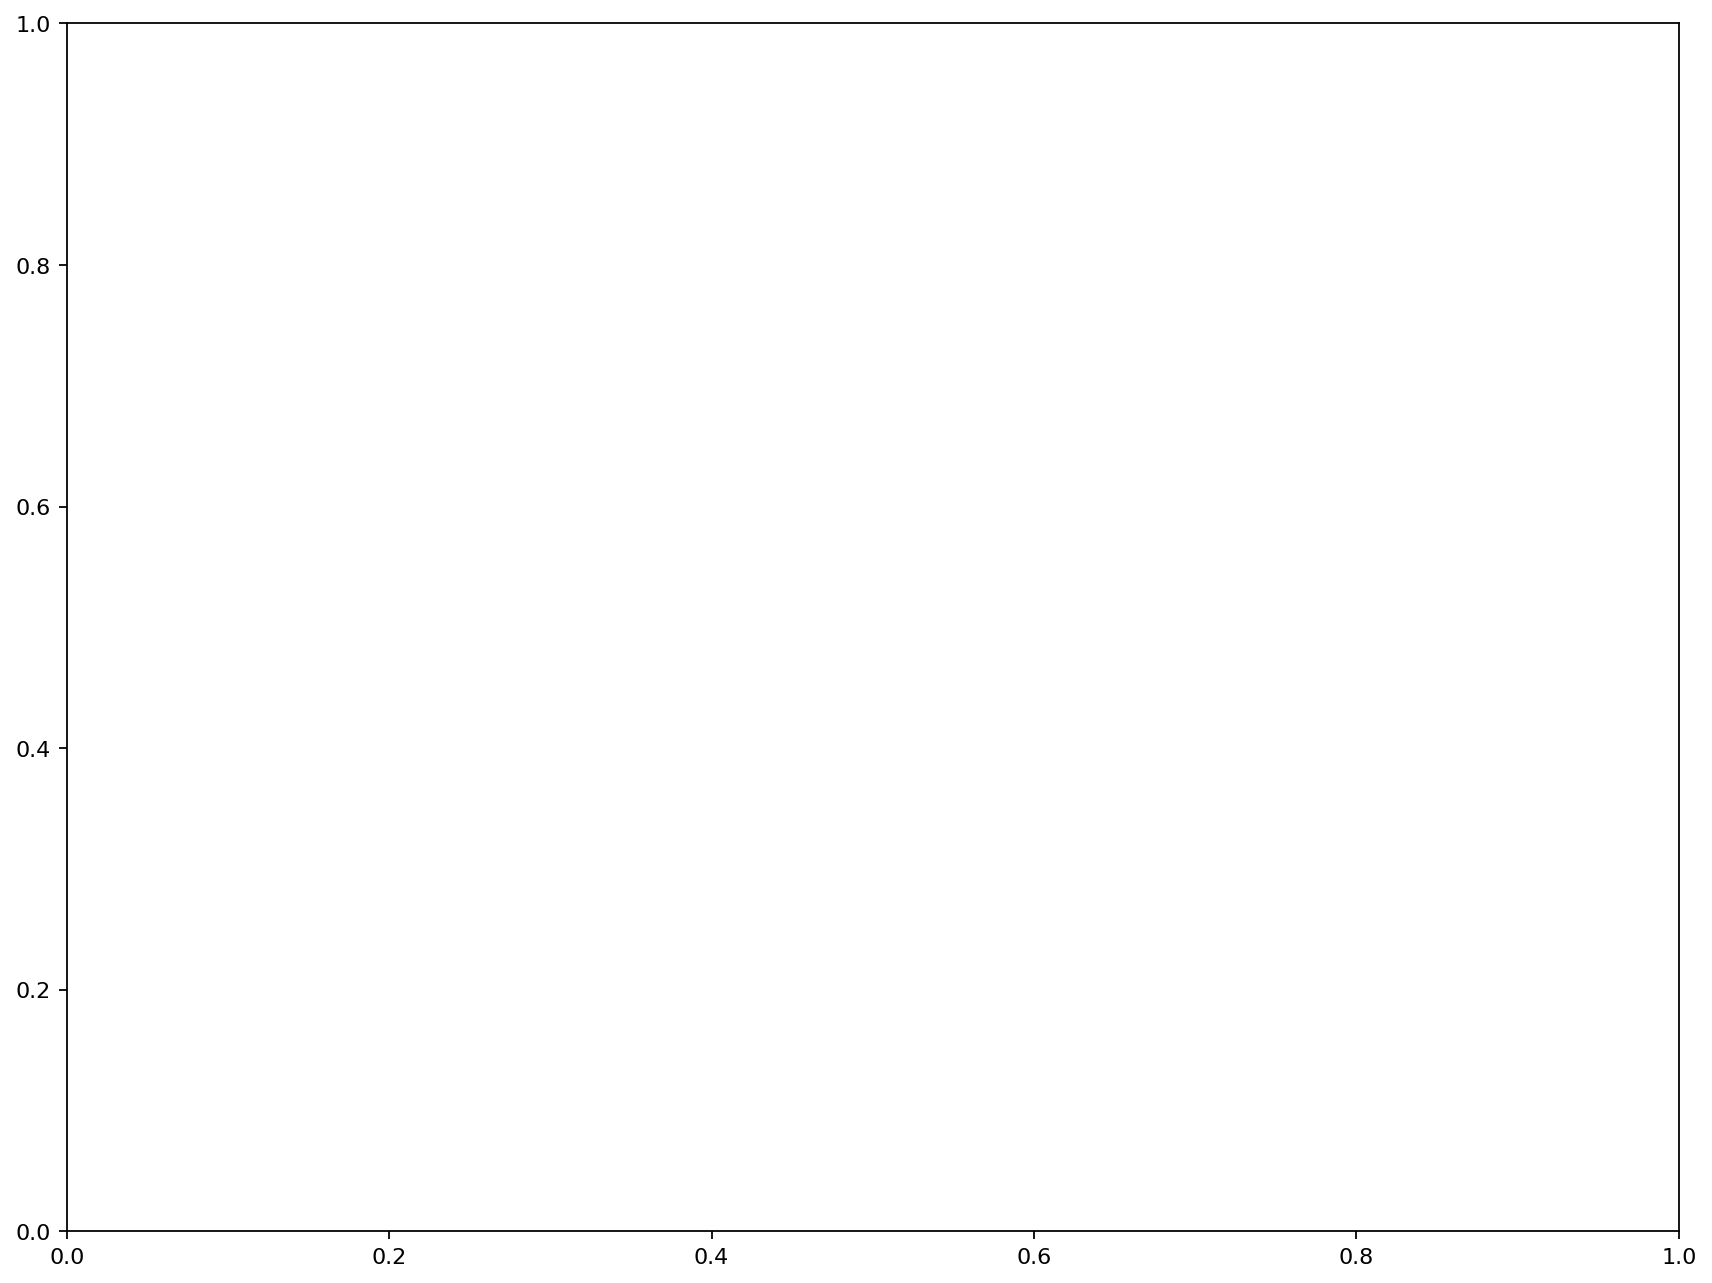

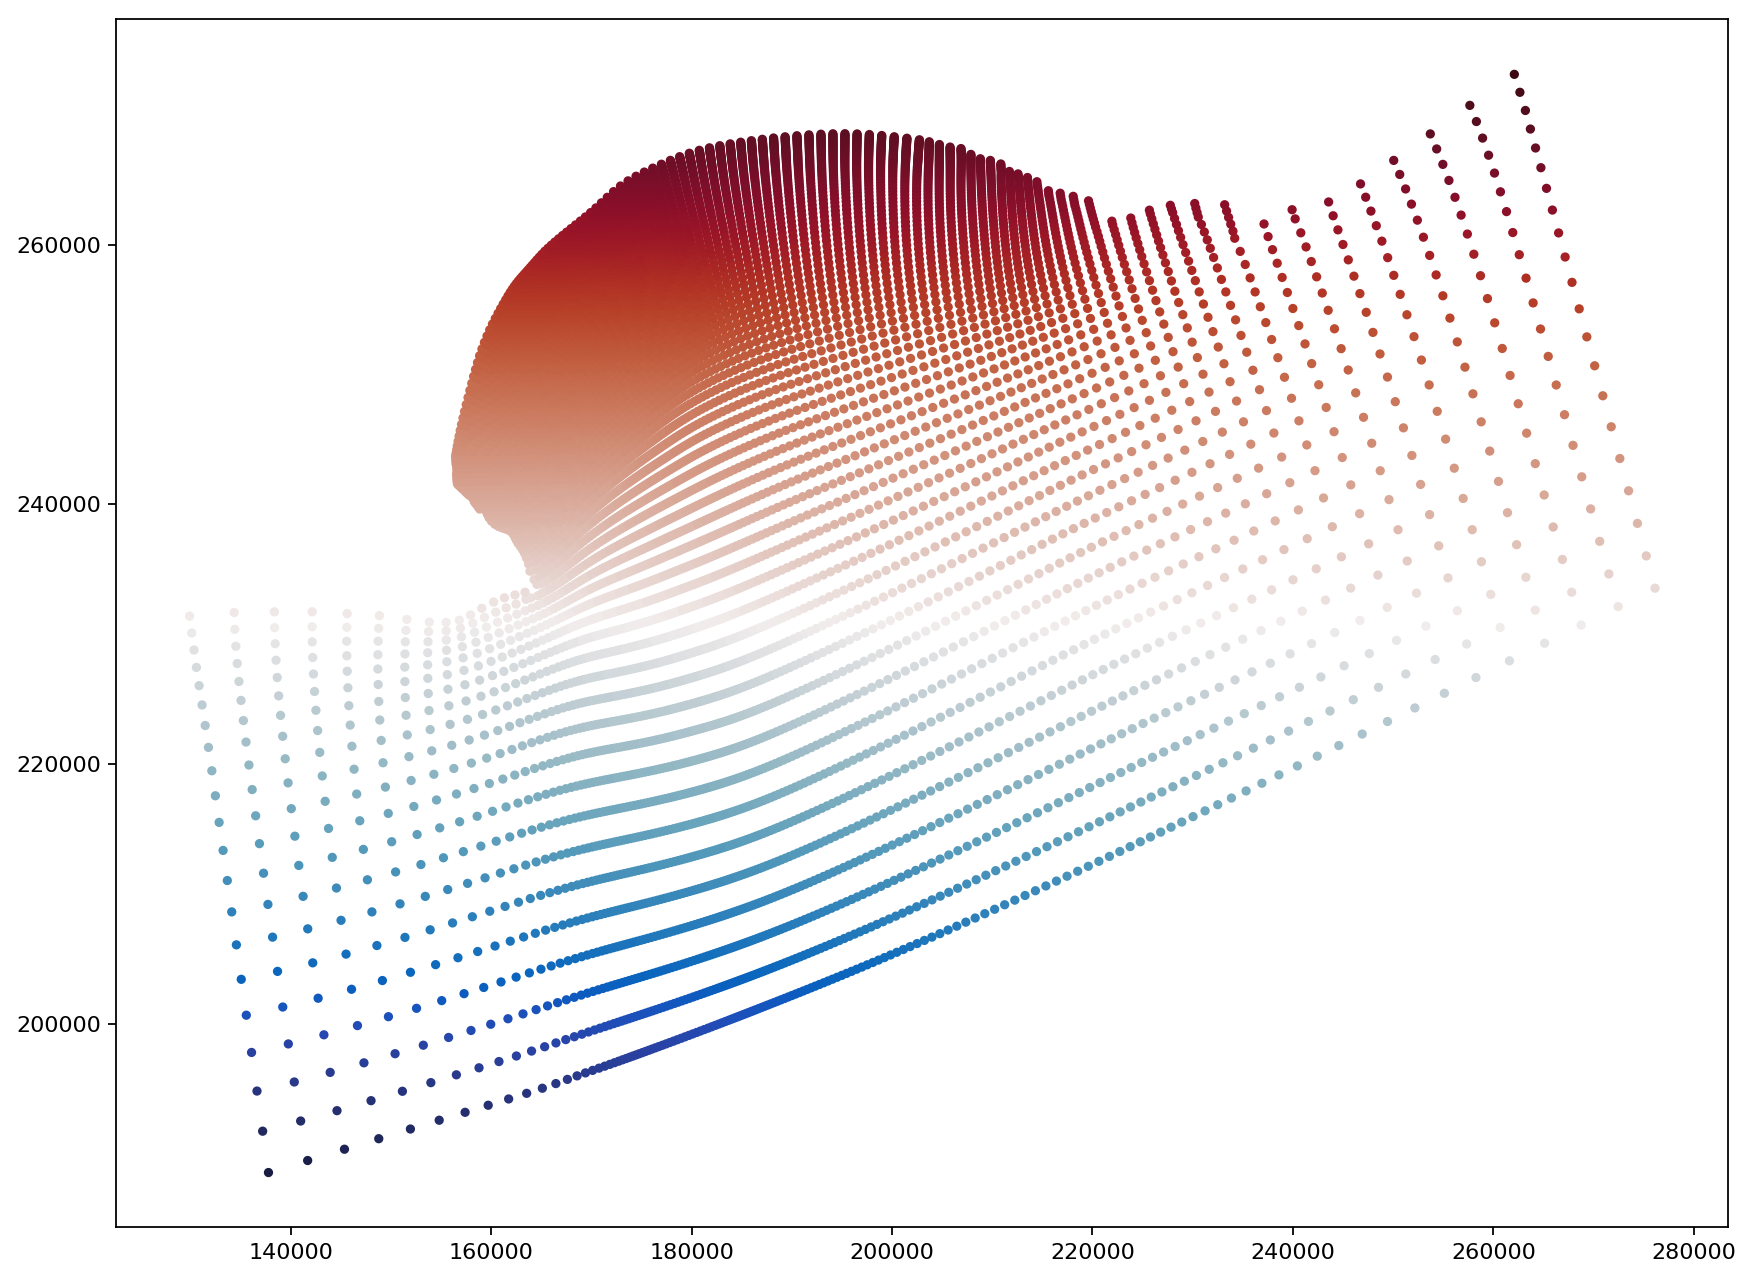

In [73]:
from netCDF4 import date2index
import netCDF4
import numpy as np
import xarray as xr, xray
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from datetime import datetime
from matplotlib.pyplot import hold, figure, pcolor, colorbar, xlabel, ylabel, title, draw, quiver, show, savefig
import cmocean as cm
import matplotlib.patches as mpatches
import pandas
import matplotlib as mpl

nc = netCDF4.Dataset("/Users/hart-davis/Desktop/Test_map.nc")
fig = figure(figsize=(13, 10), dpi=160, facecolor='w', edgecolor='k')
#ax = plt.axes(projection='3d')

lon = nc.variables["NetNode_x"][:]
lat = nc.variables["NetNode_y"][:]
u = nc.variables["ucx"][:]
v = nc.variables["ucy"][:]
w = nc.variables["ucz"][:]

plt.scatter(lon,lat,c=lat,s=10,cmap=cm.cm.balance,marker="o")

plt.show()

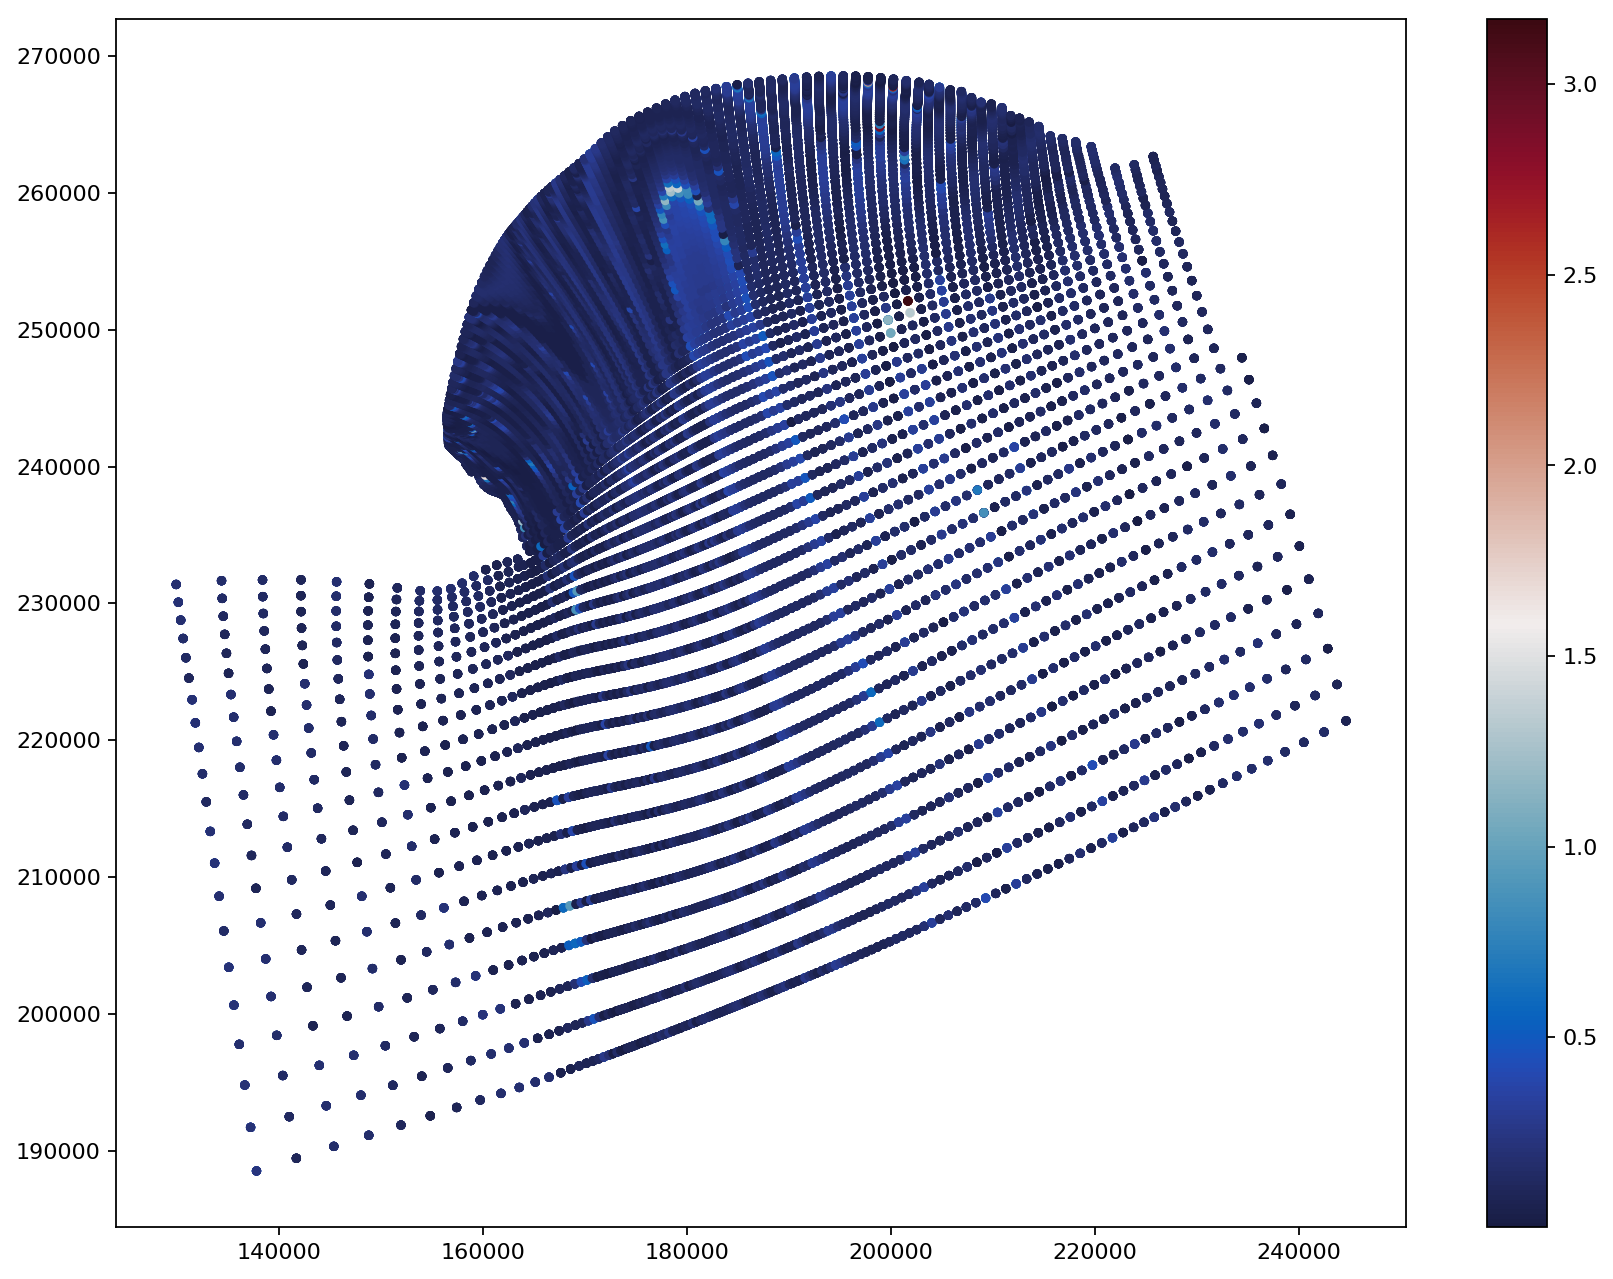

In [79]:
fig = figure(figsize=(13, 10), dpi=160, facecolor='w', edgecolor='k')

for x in range(0,10):
    vel = np.sqrt(np.square(u[1,:,x]) + np.square(v[1,:,x]))

    at = plt.scatter(lon[:len(vel)],lat[:len(vel)],c=vel,s=10,cmap=cm.cm.balance,marker="o")

plt.colorbar(at)
plt.show()

In [80]:
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

def scatter3d(x,y,z, cs, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
    scalarMap.set_array(cs)
    fig.colorbar(scalarMap,label='Test')
    plt.show()

x = np.random.uniform(0,1,50)
y = np.random.uniform(0,1,50)
z = np.random.uniform(0,1,50)

